# Montu Python 
## Astronomical ephemerides for the Ancient World
## Adapting HYG Catalogu to `MontuPython`


In [1]:
from montu import *

In [2]:
greek_letters = {
    'α':'Alp','β':'Bet','χ':'Chi','δ':'Del','ε':'Eps','η':'Eta','γ':'Gam',
    'ι':'Iot','κ':'Kap','λ':'Lam','μ':'Mu','ν':'Nu','ω':'Ome','ο':'Omi','φ':'Phi','π':'Pi',
    'ψ':'Psi','ρ':'Rho','σ':'Sig','τ':'Tau','θ':'The','υ':'Ups','ξ':'Xi','ζ':'Zet',
}
letters_greek = dict()
for let,abrev in greek_letters.items():
    letters_greek[abrev] = let

### HYG Catalogue

This will the the official source of `MontuPython`: 

- WebPage: http://www.astronexus.com/hyg, 
- GitHub: https://github.com/astronexus/HYG-Database/tree/master/hyg 

## Get the latest version of the Catalogue

In [17]:
cat_family = '3'
cat_version = 'v37'
latest_version = 'hyg_v37.csv'
Util._wget(f'https://raw.githubusercontent.com/astronexus/HYG-Database/master/hyg/v{cat_family}/hyg_{cat_version}.csv',filename=f'catalogues/hyg_{cat_version}.csv')

32.4MB [02:44, 197kB/s]                             


In [18]:
hyg_cat = pd.read_csv(f'catalogues/hyg_{cat_version}.csv')
hyg_cat.sort_values(by='mag',inplace=True)

In [19]:
print("Catalogue completeness:")
nstars = len(hyg_cat)
columns = hyg_cat.columns
for col in columns:
    ncomplete = (~(hyg_cat[col].isnull())).sum()
    print(f"\t{col}: {ncomplete}/{nstars} ({ncomplete/nstars*100:.1f}%)")

Catalogue completeness:
	id: 119626/119626 (100.0%)
	hip: 117951/119626 (98.6%)
	hd: 98885/119626 (82.7%)
	hr: 9041/119626 (7.6%)
	gl: 3801/119626 (3.2%)
	bf: 3099/119626 (2.6%)
	proper: 367/119626 (0.3%)
	ra: 119626/119626 (100.0%)
	dec: 119626/119626 (100.0%)
	dist: 119626/119626 (100.0%)
	pmra: 119626/119626 (100.0%)
	pmdec: 119626/119626 (100.0%)
	rv: 119626/119626 (100.0%)
	mag: 119626/119626 (100.0%)
	absmag: 119626/119626 (100.0%)
	spect: 116578/119626 (97.5%)
	ci: 117735/119626 (98.4%)
	x: 119626/119626 (100.0%)
	y: 119626/119626 (100.0%)
	z: 119626/119626 (100.0%)
	vx: 119626/119626 (100.0%)
	vy: 119626/119626 (100.0%)
	vz: 119626/119626 (100.0%)
	rarad: 119626/119626 (100.0%)
	decrad: 119626/119626 (100.0%)
	pmrarad: 119626/119626 (100.0%)
	pmdecrad: 119626/119626 (100.0%)
	bayer: 1537/119626 (1.3%)
	flam: 2737/119626 (2.3%)
	con: 119625/119626 (100.0%)
	comp: 119626/119626 (100.0%)
	comp_primary: 119626/119626 (100.0%)
	base: 1086/119626 (0.9%)
	lum: 119626/119626 (100.0%)
	

In [20]:
Util.print_df(hyg_cat.head(10))

Make the adjustments:

In [21]:
def change_UTF(str):
    def sub(m):
        subs = letters_greek[m.group(1)]+m.group(2)
        return subs
    utf = re.sub('(\w+)[-]*([\s]*.*)',sub,str)
    return utf

def generate_designations(row,catalogues):
    designation = row.OtherDesignations
    for cat in catalogues:
        catalogue_name = str(row[cat])
        if catalogue_name!='0' and catalogue_name!='nan' and re.match('\s*\w+\s*',catalogue_name):
            designation += f"/{cat} {catalogue_name}"
    designation = designation.lstrip('/')
    designation = designation.rstrip('/')
    return designation

def merge_designations(desig1,desig2):
    desig1 = str(desig1)
    desig2 = str(desig2)
    merge = ''
    if (desig1 != 'nan') and (desig2 != 'nan'):
        merge = desig1+'/'+desig2
    else:
        merge = desig1 if (desig1 != 'nan') else desig2
    merge = '/'.join(sorted(np.unique(merge.split('/')[::-1])))
    return merge

def strip_blanks(str):
    stripped = re.sub(r'\s{2,}',' ',str).rstrip().lstrip()
    return stripped

In [22]:
# Read
hyg_cat = pd.read_csv(f'catalogues/hyg_{cat_version}.csv')
hyg_cat.sort_values(by=['mag','ra'],inplace=True)
hyg_cat = hyg_cat.iloc[:]

# Drop columns
hyg_cat.reset_index(inplace=True)
hyg_cat['MN'] = hyg_cat.apply(lambda x:int(x.name)+1,axis=1)
hyg_cat['MN_Name'] = hyg_cat['MN'].apply(lambda x:f'MN {x}')

# Rename columns
hyg_cat.rename(columns={
    'hip':'HIP','hd':'HD','hr':'HR','gl':'Gl','bf':'BF','proper':'ProperName',
    'ra':'RAJ2000','dec':'DecJ2000','pmra':'pmRA','pmdec':'pmDec',
    'rv':'RadVel','mag':'Vmag','absmag':'Mag','spect':'SpType','ci':'B-V',
    'x':'XJ2000','y':'YJ2000','z':'ZJ2000',
    'vx':'VZJ2000','vy':'VYJ2000','vz':'VXJ2000',
    'bayer':'Bayer','flam':'Flamsteed','con':'Constellation',
    'lum':'Luminosity','index':'HYG','dist':'Distance',
    'var_min':'Vmag_min','var_max':'Vmag_max',
    'comp_primary':'Primary','base':'MultipleID',
},inplace=True)

# Conver catalogue to integers and fill with 0
for cat_field in 'HIP','HD','HR':
    hyg_cat[cat_field] = hyg_cat[cat_field].fillna(0).astype(int)

# Strip blanks
cond = (~hyg_cat['BF'].isna())
hyg_cat.loc[cond,'BF'] = hyg_cat.loc[cond,'BF'].apply(strip_blanks)

# Adjust numeric values
hyg_cat['RAJ2000'] = hyg_cat['RAJ2000'].apply(lambda x:x) # Preserve right ascension in hours

# Multiple and variable
hyg_cat['IsMultiple'] = 0
cond = hyg_cat['MultipleID'].isna()
hyg_cat.loc[~cond,'IsMultiple'] = 1
hyg_cat['IsVariable'] = 0
cond = (~hyg_cat['Vmag_min'].isna())|(~hyg_cat['var'].isna())
hyg_cat.loc[cond,'IsVariable'] = 1

# Adjdust Bayer
cond = (~hyg_cat.Bayer.isna())
hyg_cat.loc[cond,'Bayer'] = hyg_cat.loc[cond].apply(lambda x:change_UTF(x['Bayer'])+' '+x['Constellation'],axis=1)

# Adjdust Flamsteed
cond = (~hyg_cat.Flamsteed.isna())
hyg_cat.loc[cond,'Flamsteed'] = hyg_cat.loc[cond].apply(lambda x:str(int(x['Flamsteed']))+' '+x['Constellation'],axis=1)

# Generate Catalogue names
# Create catalogue names
for cat in 'HYG','MN','HIP','HD','HR':
    cond = (hyg_cat[cat] > 0)
    hyg_cat.loc[cond,f'{cat}_Name'] = hyg_cat.loc[cond,cat].apply(lambda x:f'{cat} '+str(x))

# Name
hyg_cat['Name'] = hyg_cat['ProperName'].fillna(
    hyg_cat['Bayer'].fillna(
        hyg_cat['Flamsteed'].fillna(
            hyg_cat['HD_Name'].fillna(
                hyg_cat['HIP_Name'].fillna(
                    hyg_cat['Gl']
                )
            )
        )
    )
)

# Other Designations
hyg_cat['OtherDesignations'] = hyg_cat['Name'].fillna('')
hyg_cat['OtherDesignations'] = hyg_cat.apply(lambda x:generate_designations(x,['HYG','MN','HIP','HD','HR']),axis=1)
hyg_cat['OtherDesignations'] = hyg_cat.apply(
    lambda x:merge_designations(x[f'OtherDesignations'],x[f'Bayer']),axis=1)
hyg_cat['OtherDesignations'] = hyg_cat.apply(
    lambda x:merge_designations(x[f'OtherDesignations'],x[f'Flamsteed']),axis=1)
hyg_cat['OtherDesignations'] = hyg_cat.apply(
    lambda x:merge_designations(x[f'OtherDesignations'],x[f'Gl']),axis=1)
hyg_cat['OtherDesignations'] = hyg_cat.apply(
    lambda x:merge_designations(x[f'OtherDesignations'],x[f'BF']),axis=1)

# Fill empty physical variables
for column in ['B-V']:
    hyg_cat[column] = hyg_cat[column].fillna(0)

# Columns
# Output columns
columns = ['MN','HD', 'HR', 'HIP', 'Gl', 'Name', 'OtherDesignations', 'ProperName', 'Bayer', 'Flamsteed', 'Constellation',
           'RAJ2000', 'DecJ2000', 'pmRA', 'pmDec', 'RadVel', 'Distance',
           'Vmag','Vmag_min','Vmag_max','B-V','SpType','Luminosity',
           'XJ2000','YJ2000','ZJ2000','VXJ2000','VYJ2000','VZJ2000',
           'Primary','MultipleID',
           'IsMultiple','IsVariable']
montu_cat = hyg_cat[columns]
montu_cat.to_csv(f'catalogues/montu_stellar_catalogue_{cat_version}.csv',index=False)

print("Catalogue completeness:")
cat = montu_cat
nstars = len(cat)
columns = cat.columns
for col in columns:
    ncomplete = (~(cat[col].isnull())).sum()
    print(f"\t{col}: {ncomplete}/{nstars} ({ncomplete/nstars*100:.1f}%)")

Util.print_df(hyg_cat.head(10))
Util.print_df(montu_cat.head(10))


Catalogue completeness:
	MN: 119626/119626 (100.0%)
	HD: 119626/119626 (100.0%)
	HR: 119626/119626 (100.0%)
	HIP: 119626/119626 (100.0%)
	Gl: 3801/119626 (3.2%)
	Name: 119626/119626 (100.0%)
	OtherDesignations: 119626/119626 (100.0%)
	ProperName: 367/119626 (0.3%)
	Bayer: 1537/119626 (1.3%)
	Flamsteed: 2737/119626 (2.3%)
	Constellation: 119625/119626 (100.0%)
	RAJ2000: 119626/119626 (100.0%)
	DecJ2000: 119626/119626 (100.0%)
	pmRA: 119626/119626 (100.0%)
	pmDec: 119626/119626 (100.0%)
	RadVel: 119626/119626 (100.0%)
	Distance: 119626/119626 (100.0%)
	Vmag: 119626/119626 (100.0%)
	Vmag_min: 16991/119626 (14.2%)
	Vmag_max: 16991/119626 (14.2%)
	B-V: 119626/119626 (100.0%)
	SpType: 116578/119626 (97.5%)
	Luminosity: 119626/119626 (100.0%)
	XJ2000: 119626/119626 (100.0%)
	YJ2000: 119626/119626 (100.0%)
	ZJ2000: 119626/119626 (100.0%)
	VXJ2000: 119626/119626 (100.0%)
	VYJ2000: 119626/119626 (100.0%)
	VZJ2000: 119626/119626 (100.0%)
	Primary: 119626/119626 (100.0%)
	MultipleID: 1086/119626 (

In [24]:
montu_cat.to_csv(f'catalogues/montu_stellar_catalogue_{cat_version}.csv',index=False)

In [23]:
montu_cat = pd.read_csv(f'catalogues/montu_stellar_catalogue_{cat_version}.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'catalogues/montu_stellar_catalogue_v37.csv'

Summary:

In [5]:
print("Catalogue completeness:")
cat = montu_cat
nstars = len(cat)
columns = cat.columns
for col in columns:
    ncomplete = (~(cat[col].isnull())).sum()
    print(f"\t{col}: {ncomplete}/{nstars} ({ncomplete/nstars*100:.1f}%)")

Catalogue completeness:
	MN: 119626/119626 (100.0%)
	HD: 119626/119626 (100.0%)
	HR: 119626/119626 (100.0%)
	HIP: 119626/119626 (100.0%)
	Gl: 3801/119626 (3.2%)
	Name: 119626/119626 (100.0%)
	OtherDesignations: 119626/119626 (100.0%)
	ProperName: 367/119626 (0.3%)
	Bayer: 1537/119626 (1.3%)
	Flamsteed: 2737/119626 (2.3%)
	Constellation: 119625/119626 (100.0%)
	RAJ2000: 119626/119626 (100.0%)
	DecJ2000: 119626/119626 (100.0%)
	pmRA: 119626/119626 (100.0%)
	pmDec: 119626/119626 (100.0%)
	RadVel: 119626/119626 (100.0%)
	Distance: 119626/119626 (100.0%)
	Vmag: 119626/119626 (100.0%)
	Vmag_min: 16991/119626 (14.2%)
	Vmag_max: 16991/119626 (14.2%)
	B-V: 119626/119626 (100.0%)
	SpType: 116578/119626 (97.5%)
	Luminosity: 119626/119626 (100.0%)
	XJ2000: 119626/119626 (100.0%)
	YJ2000: 119626/119626 (100.0%)
	ZJ2000: 119626/119626 (100.0%)
	VXJ2000: 119626/119626 (100.0%)
	VYJ2000: 119626/119626 (100.0%)
	VZJ2000: 119626/119626 (100.0%)
	Primary: 119626/119626 (100.0%)
	MultipleID: 1086/119626 (

In [6]:
cond_pn = (~montu_cat.ProperName.isnull())
print("Number of stars with proper name: ",cond_pn.sum())
cond_by = (~montu_cat.Bayer.isnull())
print("Number of stars with Bayer name: ",cond_by.sum())
cond_fm = (~montu_cat.Flamsteed.isnull())
print("Number of stars with Flamsteed name: ",cond_fm.sum())
cond_all = (cond_pn)&(cond_by)&(cond_fm)
print("Number of proper, Bayer and Flamsteed: ",cond_all.sum())

Number of stars with proper name:  367
Number of stars with Bayer name:  1537
Number of stars with Flamsteed name:  2737
Number of proper, Bayer and Flamsteed:  263


In [12]:
cond = (montu_cat.Vmag<=6.5)
nvis = len(np.unique(montu_cat.loc[cond,'HD']))
print("Number of naked eye stars: ",nvis)

Number of naked eye stars:  8896


In [8]:
D2H(montu_cat[montu_cat.HD == 151613].RAJ2000)

'251:19:27.084'

In [11]:
for col in montu_cat.columns:
    print(f"- *`{col}`*: ")

- *`MN`*: 
- *`HD`*: 
- *`HR`*: 
- *`HIP`*: 
- *`Gl`*: 
- *`Name`*: 
- *`OtherDesignations`*: 
- *`ProperName`*: 
- *`Bayer`*: 
- *`Flamsteed`*: 
- *`Constellation`*: 
- *`RAJ2000`*: 
- *`DecJ2000`*: 
- *`pmRA`*: 
- *`pmDec`*: 
- *`RadVel`*: 
- *`Distance`*: 
- *`Vmag`*: 
- *`Vmag_min`*: 
- *`Vmag_max`*: 
- *`B-V`*: 
- *`SpType`*: 
- *`Luminosity`*: 
- *`XJ2000`*: 
- *`YJ2000`*: 
- *`ZJ2000`*: 
- *`VXJ2000`*: 
- *`VYJ2000`*: 
- *`VZJ2000`*: 
- *`Primary`*: 
- *`MultipleID`*: 
- *`IsMultiple`*: 
- *`IsVariable`*: 


In [13]:
print("Catalogue completeness:")
cat = montu_cat
nstars = len(cat)
columns = cat.columns
for col in columns:
    ncomplete = (~(cat[col].isnull())).sum()
    print(f"\t{col}: {ncomplete}/{nstars} ({ncomplete/nstars*100:.1f}%)")

cond_pn = (~montu_cat.ProperName.isnull())
print("Number of stars with proper name: ",cond_pn.sum())
cond_by = (~montu_cat.Bayer.isnull())
print("Number of stars with Bayer name: ",cond_by.sum())
cond_fm = (~montu_cat.Flamsteed.isnull())
print("Number of stars with Flamsteed name: ",cond_fm.sum())
cond_all = (cond_pn)&(cond_by)&(cond_fm)
print("Number of proper, Bayer and Flamsteed: ",cond_all.sum())

cond = (montu_cat.Vmag<=6.5)
nvis = len(np.unique(montu_cat.loc[cond,'HD']))
print("Number of naked eye stars: ",nvis)

Catalogue completeness:
	MN: 119626/119626 (100.0%)
	HD: 119626/119626 (100.0%)
	HR: 119626/119626 (100.0%)
	HIP: 119626/119626 (100.0%)
	Gl: 3801/119626 (3.2%)
	Name: 119626/119626 (100.0%)
	OtherDesignations: 119626/119626 (100.0%)
	ProperName: 367/119626 (0.3%)
	Bayer: 1537/119626 (1.3%)
	Flamsteed: 2737/119626 (2.3%)
	Constellation: 119625/119626 (100.0%)
	RAJ2000: 119626/119626 (100.0%)
	DecJ2000: 119626/119626 (100.0%)
	pmRA: 119626/119626 (100.0%)
	pmDec: 119626/119626 (100.0%)
	RadVel: 119626/119626 (100.0%)
	Distance: 119626/119626 (100.0%)
	Vmag: 119626/119626 (100.0%)
	Vmag_min: 16991/119626 (14.2%)
	Vmag_max: 16991/119626 (14.2%)
	B-V: 119626/119626 (100.0%)
	SpType: 116578/119626 (97.5%)
	Luminosity: 119626/119626 (100.0%)
	XJ2000: 119626/119626 (100.0%)
	YJ2000: 119626/119626 (100.0%)
	ZJ2000: 119626/119626 (100.0%)
	VXJ2000: 119626/119626 (100.0%)
	VYJ2000: 119626/119626 (100.0%)
	VZJ2000: 119626/119626 (100.0%)
	Primary: 119626/119626 (100.0%)
	MultipleID: 1086/119626 (

## Map of the stars

In [5]:
import montu
from montu import D2H,PRINTDF,TABLEDF,DEG,RAD
montu.Util.load_kernels()
allstars = montu.Stars()
from matplotlib import cm
import matplotlib.pyplot as plt

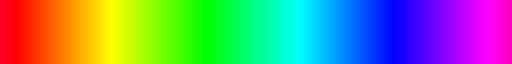

In [6]:
rainbow = cm.get_cmap('gist_rainbow')
rainbow

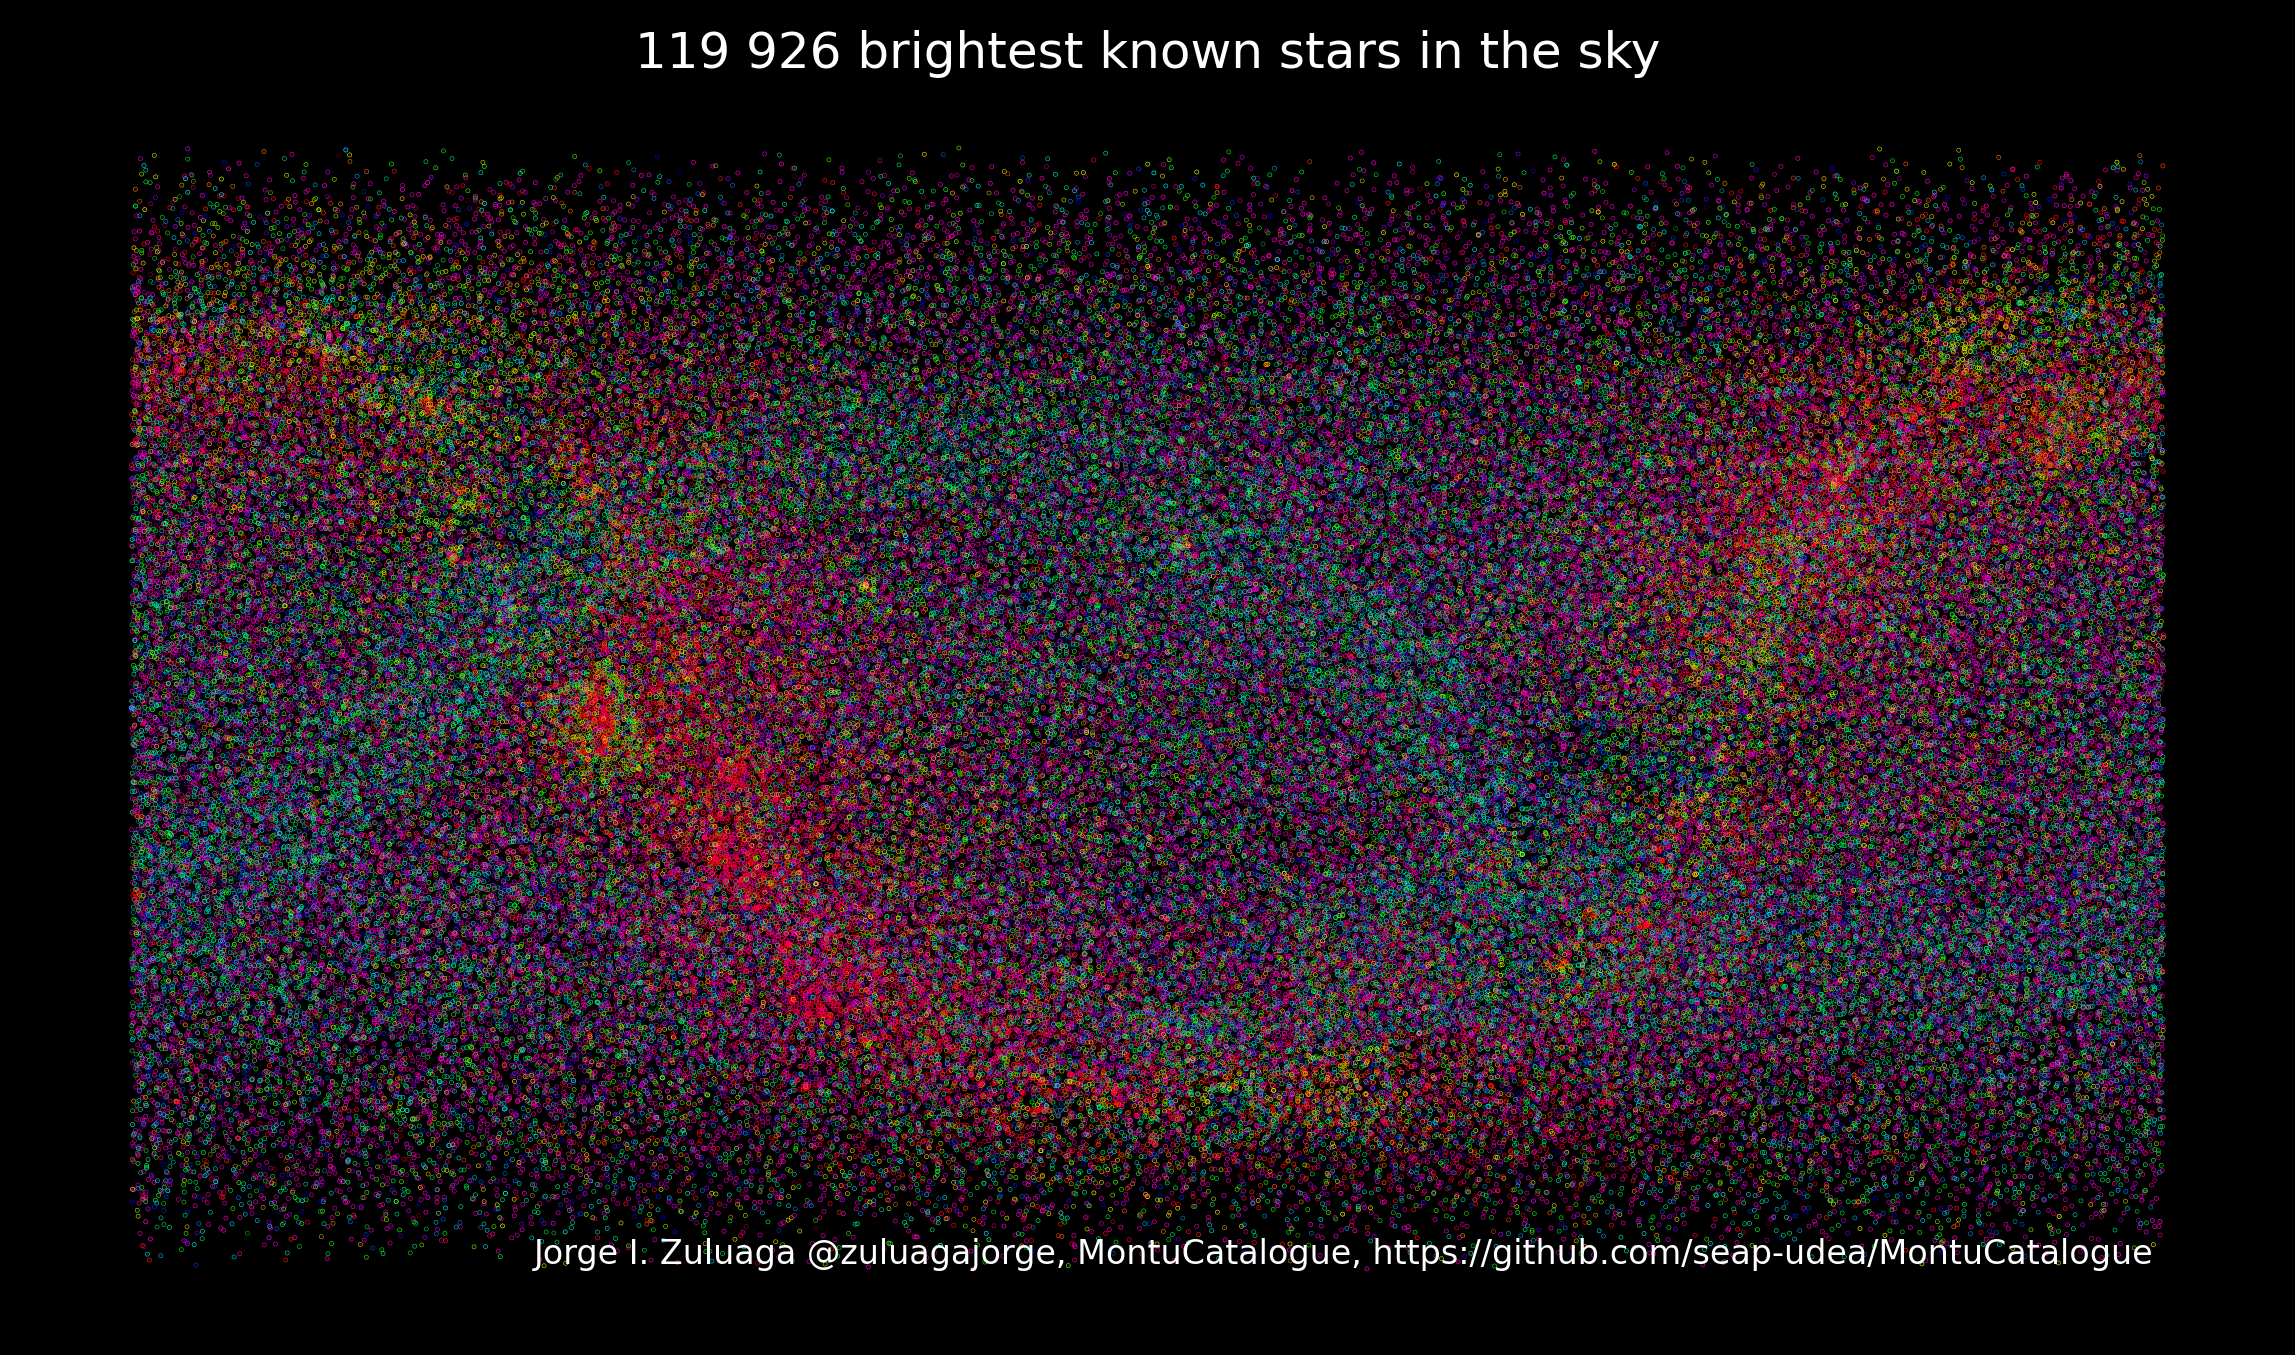

In [9]:
plt.style.use('dark_background')
fig,ax=plt.subplots(figsize=(10,6),dpi=300)
ax.set_position((0, 0, 1, 1))
minsize=0.01
maxsize=0.1
mag2size=montu.Util._linear_map([-2,12],[maxsize,minsize])
ind2color=montu.Util._linear_map([-0.2,2.5],[1,0])
ax.scatter(allstars.data.RAJ2000,allstars.data.DecJ2000,
s=mag2size(allstars.data.Vmag),c=rainbow(allstars.data['B-V']))
ax.axis('off')
ax.set_title('119 926 brightest known stars in the sky')
ax.text(0.95,0.05,'Jorge I. Zuluaga @zuluagajorge, MontuCatalogue, https://github.com/seap-udea/MontuCatalogue',
transform = ax.transAxes,fontsize=8,ha='right')
fig.tight_layout()
fig.savefig('map-allstars-colors.png',bbox_inches='tight')